In [1]:
#Importing required packages
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [2]:
# cleaned up '#' in txt file before reading -> for correct header
df = pd.read_csv("testpattern06_d4.0_R3.0_roving.txt",delim_whitespace=True)
df=df.drop(['#'], axis=1)
df.head()

,Stitch_number_modified,Stitch_path_length,x,y,measured_x1,measured_y1,measured_x2,measured_y2,measured_xm,measured_ym,Deviation_tot,Width,Radius_loc,Radius_locav,Radius_locav2,Radius_locav3
0,1,0.0000,511.3638,-19.0811,510.8245,-17.9730,511.8639,-20.1088,511.3442,-19.0409,0.0447,2.3753,inf,299.8505,17.5033,11.7315
1,1,0.9591,512.3229,-19.0894,511.7820,-18.0891,512.8518,-20.0677,512.3169,-19.0784,0.0125,2.2493,inf,150.5194,15.6020,11.2740
2,1,1.9183,513.2820,-19.0977,512.7094,-18.1517,513.8795,-20.0851,513.2945,-19.1184,0.0242,2.2598,inf,81.0540,13.9990,10.8555
3,1,2.9018,514.2654,-19.1060,513.6625,-18.2269,514.9383,-20.0871,514.3004,-19.1570,0.0618,2.2557,-146.6106,45.6545,12.6165,10.4644
4,1,3.9667,515.3302,-19.1225,514.5880,-18.1910,516.1352,-20.1328,515.3616,-19.1619,0.0504,2.4828,-470.9179,26.2507,11.3705,10.0818


In [3]:
#checking information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Stitch_number_modified  2155 non-null   int64  
 1   Stitch_path_length      2155 non-null   float64
 2   x                       2155 non-null   float64
 3   y                       2155 non-null   float64
 4   measured_x1             2155 non-null   float64
 5   measured_y1             2155 non-null   float64
 6   measured_x2             2155 non-null   float64
 7   measured_y2             2155 non-null   float64
 8   measured_xm             2155 non-null   float64
 9   measured_ym             2155 non-null   float64
 10  Deviation_tot           2155 non-null   float64
 11  Width                   2155 non-null   float64
 12  Radius_loc              2155 non-null   float64
 13  Radius_locav            2155 non-null   float64
 14  Radius_locav2           2155 non-null   

In [4]:
#sliding window part
def slidingWindow(x, y,  stitchwindow=5):
    x_values = np.lib.stride_tricks.sliding_window_view(x, stitchwindow)
    y_values = np.lib.stride_tricks.sliding_window_view(y, stitchwindow)
    x_values = x_values - x_values[:, stitchwindow // 2][:, np.newaxis]
    y_values = y_values - y_values[:, stitchwindow // 2][:, np.newaxis]
    target = np.lib.stride_tricks.sliding_window_view(df['Deviation_tot'], stitchwindow)[:,stitchwindow//2].copy()
    features = np.concatenate((x_values, y_values), axis=1)
    # drop 0 columns:
    features = features[:,[i for i in range(2*stitchwindow) if i!=stitchwindow//2 and i!=(stitchwindow+stitchwindow//2)]].copy()
    #random permutation of dataset
    ind = np.random.permutation(np.arange(len(features))) 
    features = features[ind].copy()
    target = target[ind].copy()[:,np.newaxis]
    return features, target, ind  
    

In [5]:
features, target, sortind =slidingWindow(df['x'].values,df['y'].values, stitchwindow=5)

# resort data for later evaluation with backup data in original order
resort = np.argsort(sortind)
backupfeatures, backuptarget = features[resort,:].copy(), target[resort,:].copy()

# split validation before enrichment -> because data is shuffled we just split after 20% 
fval = 0.2 
Nval = int(features.shape[0]*fval)
val_features, val_target = features[:Nval,:].copy(), target[:Nval,:].copy()
features, target = features[Nval:,:].copy(), target[Nval:,:].copy() # now only 80% are used for enrichment

In [6]:
#Transform to tensor
features=torch.Tensor(features)
target = torch.Tensor(target)
val_features=torch.Tensor(val_features)
val_target = torch.Tensor(val_target)


In [7]:
#CNN structure
class MyModel(nn.Module):
    def __init__(self, n_features):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(n_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16,8)
        self.layer5 = nn.Linear(8,1)
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.layer4(x)
        x = torch.relu(x)
        x = self.layer5(x)
        return x

In [8]:
#compiling the model
model = MyModel(n_features=features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
#Training the models

losses = []
val_losses = []
for epoch in range(3000):

    # Forward pass
    output = model(features)

    # Compute loss
    loss = criterion(output, target)

    # Backward pass and update
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

 # Print loss
    if epoch % 10 == 0:
        losses.append(float(loss.item()))
        # evaluate validation each time here:
        valloss = criterion(model(val_features), val_target)
        val_losses.append(float(valloss.item()))
        print(f'Epoch {epoch}, Loss: {loss.item()}, validation loss {valloss.item()}')

Epoch 0, Loss: 2.3081679344177246, validation loss 2.841092824935913
Epoch 10, Loss: 2.0651652812957764, validation loss 2.6006555557250977
Epoch 20, Loss: 2.010709047317505, validation loss 2.564485549926758
Epoch 30, Loss: 1.9468222856521606, validation loss 2.511824131011963
Epoch 40, Loss: 1.8478237390518188, validation loss 2.4166970252990723
Epoch 50, Loss: 1.6957978010177612, validation loss 2.2782273292541504
Epoch 60, Loss: 1.4848705530166626, validation loss 2.0901622772216797
Epoch 70, Loss: 1.277936577796936, validation loss 1.8862849473953247
Epoch 80, Loss: 1.1319161653518677, validation loss 1.7041901350021362
Epoch 90, Loss: 1.0230274200439453, validation loss 1.5629324913024902
Epoch 100, Loss: 0.9247829914093018, validation loss 1.4601850509643555
Epoch 110, Loss: 0.8189713358879089, validation loss 1.3725085258483887
Epoch 120, Loss: 0.7044629454612732, validation loss 1.2686328887939453
Epoch 130, Loss: 0.5786964297294617, validation loss 1.1623398065567017
Epoch 14

Epoch 1170, Loss: 0.061443209648132324, validation loss 0.2253287434577942
Epoch 1180, Loss: 0.06130744889378548, validation loss 0.22497819364070892
Epoch 1190, Loss: 0.0609489269554615, validation loss 0.22487516701221466
Epoch 1200, Loss: 0.05971354991197586, validation loss 0.22348971664905548
Epoch 1210, Loss: 0.05904226005077362, validation loss 0.2225630134344101
Epoch 1220, Loss: 0.05901803821325302, validation loss 0.22322307527065277
Epoch 1230, Loss: 0.06009417027235031, validation loss 0.22414037585258484
Epoch 1240, Loss: 0.057981859892606735, validation loss 0.22264069318771362
Epoch 1250, Loss: 0.05845503881573677, validation loss 0.22277821600437164
Epoch 1260, Loss: 0.0576900988817215, validation loss 0.21952709555625916
Epoch 1270, Loss: 0.05677821859717369, validation loss 0.21994082629680634
Epoch 1280, Loss: 0.05632680281996727, validation loss 0.2197910100221634
Epoch 1290, Loss: 0.05591782182455063, validation loss 0.21947689354419708
Epoch 1300, Loss: 0.05728761

Epoch 2280, Loss: 0.03353026136755943, validation loss 0.19118031859397888
Epoch 2290, Loss: 0.03328833729028702, validation loss 0.19072183966636658
Epoch 2300, Loss: 0.03201283514499664, validation loss 0.19169308245182037
Epoch 2310, Loss: 0.03020278736948967, validation loss 0.1859128326177597
Epoch 2320, Loss: 0.02989203855395317, validation loss 0.18643027544021606
Epoch 2330, Loss: 0.03126903623342514, validation loss 0.184849813580513
Epoch 2340, Loss: 0.031147683039307594, validation loss 0.18368756771087646
Epoch 2350, Loss: 0.03260952979326248, validation loss 0.19872240722179413
Epoch 2360, Loss: 0.029873082414269447, validation loss 0.19151969254016876
Epoch 2370, Loss: 0.029594650492072105, validation loss 0.1873525232076645
Epoch 2380, Loss: 0.029718197882175446, validation loss 0.18620039522647858
Epoch 2390, Loss: 0.029078571125864983, validation loss 0.19015398621559143
Epoch 2400, Loss: 0.028998348861932755, validation loss 0.18415936827659607
Epoch 2410, Loss: 0.030

Text(0.5, 1.0, 'Basic Model')

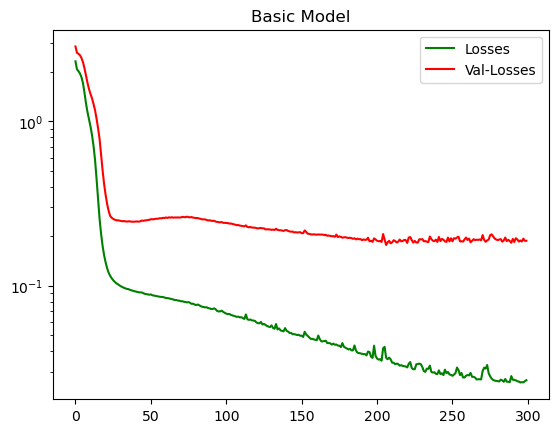

In [10]:
# plotting the losses in log plot
plt.semilogy(losses,color=('green'),label=('Losses'))
plt.semilogy(val_losses,color=('red'),label=('Val-Losses'))
plt.legend()
plt.title('Basic Model')


In [11]:
#save model, later on we can directly use.
torch.save(model, 'basicmodel.pt')

#we can use model from here  without running epochs
#try printing
#model = torch.load('basicmodel.pt')

In [12]:
y_pred = model(torch.Tensor(backupfeatures))
print(f"MSE over the model prediction: {mean_absolute_error(backuptarget.tolist(), y_pred.tolist())}")


MSE over the model prediction: 0.1278406356055229


In [13]:
prediction = model(torch.Tensor(backupfeatures))[:,0]
prediction = prediction.detach().numpy().flatten()

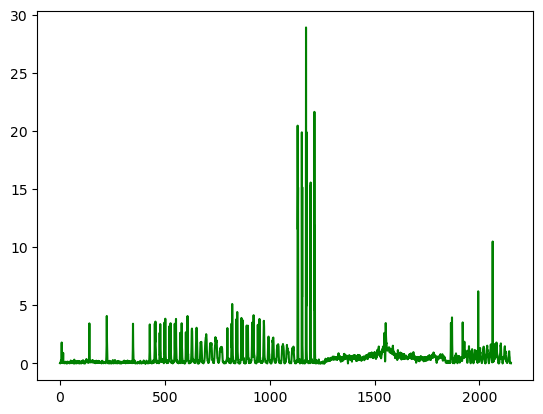

In [15]:
plt.plot(backuptarget.flatten(),color=('green'))

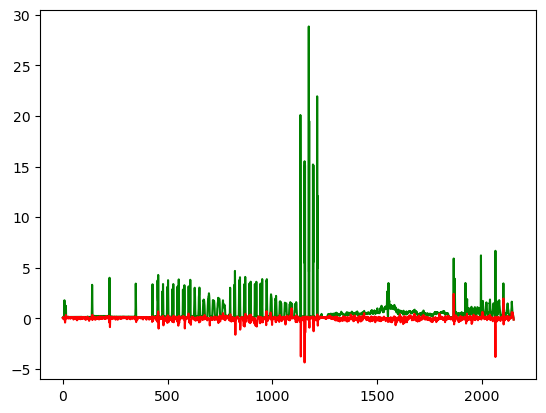

In [16]:

plt.plot(prediction, color='green')
plt.plot(prediction-backuptarget.flatten(),color='red')